In [1]:
import pandas as pd
import os, gzip
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn import metrics

snps = pd.read_table("/lustrehome/pietrolucamazzacuva/ROC-AUC_files_HEK2937_Pecori/snp147.txt.gz", 
                     usecols=[1, 3, 6, 8, 9], header=None, compression="gzip")
snps.columns = ["Region", "Position", "Strand", "Reference_Base", "Alternative_Base"]
indexfoward = snps[snps.loc[:, "Strand"]=="+"].index.tolist()
indexreverse = snps[snps.loc[:, "Strand"]=="-"].index.tolist()
snps.iloc[indexfoward, 2] = 1
snps.iloc[indexreverse, 2] = 0

In [3]:
import random
from random import uniform

def return_probability(_):
    return uniform(0.0, 0.499999999)


tables = [["outTable_599710609", "outTable_905657585"], 
          ["outTable_572868058", "outTable_364841872"],
          ["outTable_110067244", "outTable_597789462"]]

outputs = [["RED-ML-RESULTS", "RED-ML-RESULTS4"], 
           ["RED-ML-RESULTS2", "RED-ML-RESULTS5"],
           ["RED-ML-RESULTS3", "RED-ML-RESULTS6"]]

datapath = "/lustre/home/pietrolucamazzacuva/ROC-AUC_files_HEK2937_Pecori"
sitespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T"

y_true_red = []
y_pred_red = []

siteslist = []
for filename in os.listdir(sitespath):
    if filename.find("_candidates_bona_fide_sites_2") == -1:
        if filename.find("_bona_fide_sites_2.tsv") !=-1:
            if not len(filename) == 40:
                siteslist.append(filename)

for i in range(3):
    
    sites = pd.read_table(os.path.join(sitespath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites.tsv"), usecols=["Region", "Position", "Class"])
    
    wt = pd.read_table(os.path.join(sitespath, tables[i][0]+"_predictions.tsv"), usecols=["Region", "Position", "Strand"])
    siteswt = sites.merge(wt, how="inner", on=["Region", "Position"])
    
    ko = pd.read_table(os.path.join(sitespath, tables[i][1]+"_predictions.tsv"), usecols=["Region", "Position", "Strand"])
    sitesko = sites.merge(ko, how="inner", on=["Region", "Position"])
    
    sites = pd.concat([siteswt, sitesko], axis=0)
    sites.reset_index(drop=True, inplace=True)
    sites.drop_duplicates(keep="first", inplace=True)
    sites.reset_index(drop=True, inplace=True)
    
    for j in range(2):
    

        predictions = pd.read_table(os.path.join(datapath, f"{outputs[i][j]}/RNA_editing.sites.txt"), skiprows=1, header=None, low_memory=False)
        predictions.columns=["Region", "Position", "Coverage", "Reference_Base", "Reference_Base_Count", 
                                             "Alternative_Base", "Alternative_Base_Count", "Editing_Probability"]
        predictions["index"]=[i for i in range(predictions.shape[0])]
        merged = predictions.merge(snps, how="inner", on=["Region", "Position"], suffixes=('_Prediction', '_SNPs'))
        
        mergedfiltered = merged[
                                (
                                 (merged["Reference_Base_Prediction"]=="A") & 
                                 (merged["Alternative_Base_Prediction"]=="G") &
                                 (merged["Reference_Base_SNPs"]=="A") &
                                 (merged["Alternative_Base_SNPs"].str.find("G")!=-1)
                                ) |
                                (
                                 (merged["Reference_Base_Prediction"]=="T") & 
                                 (merged["Alternative_Base_Prediction"]=="C") &
                                 (merged["Reference_Base_SNPs"]=="T") &
                                 (merged["Alternative_Base_SNPs"].str.find("C")!=-1)
                                )
                               ]
        
        indexdrop = mergedfiltered["index"].tolist()
        predictions.drop(indexdrop, axis=0, inplace=True)
        
        predictions = predictions[
                                  (
                                   (predictions["Reference_Base"]=="A") & 
                                   (predictions["Alternative_Base"]=="G") 
                                  ) |
                                  (
                                   (predictions["Reference_Base"]=="T") & 
                                   (predictions["Alternative_Base"]=="C") 
                                  )
                                 ]
        
        
        predictions.reset_index(drop=True, inplace=True)
        mergedfiltered.reset_index(drop=True, inplace=True)
        
        pos = predictions.merge(sites, how="inner", on=["Region", "Position"])
        
        pos = pos[
                  (
                   (pos["Reference_Base"]=="A") & 
                   (pos["Alternative_Base"]=="G") &
                   (pos["Strand"]==1)
                  ) |
                  (
                   (pos["Reference_Base"]=="T") & 
                   (pos["Alternative_Base"]=="C") &
                   (pos["Strand"]==0)
                  )
                 ]
        
        neg = mergedfiltered.merge(sites, how="inner", on=["Region", "Position", "Strand"])
        
        neg = neg[
                  (
                   (neg["Reference_Base_Prediction"]=="A") & 
                   (neg["Alternative_Base_Prediction"]=="G") &
                   (neg["Strand"]==1)
                  ) |
                  (
                   (neg["Reference_Base_Prediction"]=="T") & 
                   (neg["Alternative_Base_Prediction"]=="C") &
                   (neg["Strand"]==0)
                  )
                 ]
        
        
        neg.loc[:, "Editing_Probability"] = 0.0

        print(len(pos))
        print(len(neg))
        
        y_true_red += pos.loc[:, "Class"].tolist() + neg.loc[:, "Class"].tolist()
        y_pred_red += pos.loc[:, "Editing_Probability"].tolist() + neg.loc[:, "Editing_Probability"].tolist()
        
        del predictions, merged, mergedfiltered, pos, neg




1223
568
286
441
1060
531
307
451
702
445
298
423


In [6]:
def return_region(x):
    return "chr{}".format(x)

datapath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/HEK293T_editpredict"
sitespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T"

y_true_edi = []
y_pred_edi = []

for i in range(3):
    
    sites = pd.read_table(os.path.join(sitespath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites.tsv"),
                          sep="\t", usecols=["Region", "Position", "Class"])
    for j in range(2):

        cols = ["Chromosome", "Position", "NO_prob"]
        
        for annotation in ["alu", "not_alu"]:
            
            prediction = pd.read_table(os.path.join(datapath, f"Predict_result_{tables[i][j]}_{annotation}.txt"), usecols=cols)
            prediction.loc[:, "Editing_Probability"] = 1.0 - prediction.loc[:, "NO_prob"]
            prediction.drop("NO_prob", axis=1, inplace=True)
            prediction.columns = ["Region", "Position", "Editing_Probability"]
            prediction.loc[:, "Region"] = prediction.loc[:, "Region"].apply(return_region)
            prediction = prediction.merge(sites, how="inner", on=["Region", "Position"])

            y_true_edi += prediction.loc[:, "Class"].tolist()
            y_pred_edi += prediction.loc[:, "Editing_Probability"].tolist()

In [7]:
datapath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T"

y_true_redi = []
y_pred_redi = []

for i in range(3):

    sites = pd.read_table(os.path.join(datapath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites.tsv"),
                          sep="\t", usecols=["Region", "Position", "Class"])

    cols =  ["Region", "Position", "Strand", "Editing_Probability"]
    wt = pd.read_csv(os.path.join(datapath, f"{tables[i][0]}_predictions.tsv"), sep="\t", usecols=cols)
    adars_inactive = pd.read_csv(os.path.join(datapath, f"{tables[i][1]}_predictions.tsv"), sep="\t", usecols=cols)

    wt = wt.merge(sites, how="inner", on=["Region", "Position"])

    neg = sites[sites.loc[:, "Class"] == 0]
    adars_inactive = adars_inactive.merge(sites, how="inner", on=["Region", "Position"])

    y_true_redi += wt.loc[:, "Class"].tolist() + adars_inactive.loc[:, "Class"].tolist()
    y_pred_redi += wt.loc[:, "Editing_Probability"].tolist() + adars_inactive.loc[:, "Editing_Probability"].tolist()



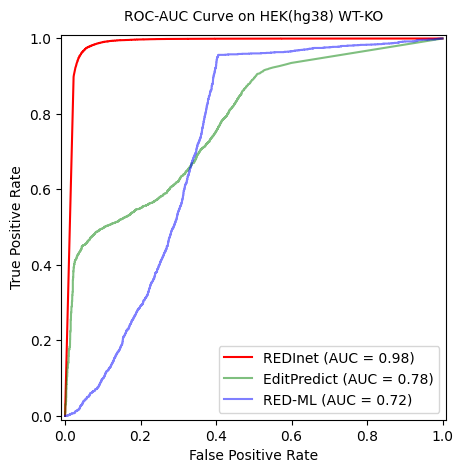

In [8]:
path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T"

fig, ax = plt.subplots(figsize=(5.5, 5))
fpr_redi, tpr_redi, thresholds_redi = metrics.roc_curve(y_true_redi, y_pred_redi)
AUC_redi = metrics.auc(fpr_redi, tpr_redi,)
ROC = metrics.RocCurveDisplay(fpr=fpr_redi, tpr=tpr_redi, roc_auc=AUC_redi).plot(ax=ax, color="red", name="REDInet")
fpr_edi, tpr_edi, thresholds_edi = metrics.roc_curve(y_true_edi, y_pred_edi)
AUC_edi = metrics.auc(fpr_edi, tpr_edi)
ROC_edi = metrics.RocCurveDisplay(fpr=fpr_edi, tpr=tpr_edi, roc_auc=AUC_edi).plot(ax=ax, color="green", name="EditPredict", alpha=0.5)    
fpr_red, tpr_red, thresholds_red = metrics.roc_curve(y_true_red, y_pred_red)
AUC_red = metrics.auc(fpr_red, tpr_red)
ROC_red = metrics.RocCurveDisplay(fpr=fpr_red, tpr=tpr_red, roc_auc=AUC_red).plot(ax=ax, color="blue", name="RED-ML", alpha=0.5)
ax.set_title(f"ROC-AUC Curve on HEK(hg38) WT-KO", fontsize=10, pad=10)
plt.savefig(f"{path}/ROC-AUC_on_HEK293T_REDInet_Edit_Predict_RED-ML_WT_KO_hg38.tiff", dpi=300, facecolor='white', transparent=False) 
plt.show()